## Klasyfikacja Cen – Wprowadzenie

Celem tego notatnika jest zbudowanie i analiza **modelu klasyfikacji cen** dla ofert noclegowych.  
Zamiast przewidywać dokładną wartość ceny, problem został sformułowany jako **zadanie klasyfikacji wieloklasowej**, w którym każda oferta przypisywana jest do jednej z trzech kategorii cenowych:

- **low** – niska cena
- **normal** – cena średnia/rynkowa
- **high** – wysoka cena

Kategorie cenowe definiowane są **w odniesieniu do podobnych ofert**, na podstawie percentyli cen w grupach tworzonych według:
- **lokalizacji oferty**  
- **typu pokoju**

Takie podejście sprawia, że zmienna docelowa jest bardziej realistyczna i odporna na odstające wartości, ponieważ odzwierciedla lokalne warunki rynkowe, a nie globalne progi cenowe.

---

### Motywacja

Bezpośrednie przewidywanie ceny może być podatne na szumy i wartości odstające. Z praktycznego punktu widzenia (np. w systemach rekomendacji lub analizie rynku) często bardziej użyteczne jest określenie, czy oferta jest:
- niedoszacowana,
- wyceniona prawidłowo,
- czy przewyższająca cenowo konkurencję  

w odniesieniu do podobnych ofert.

Sformułowanie problemu jako klasyfikacji pozwala na:
- łatwiejszą interpretację modelu,
- intuicyjną ocenę wyników (F1-score, macierz pomyłek),
- oraz bardziej praktyczne wnioski.

---

### Podejście modelowe

Notatnik obejmuje:
- tworzenie klas cenowych na podstawie percentyli w grupach,
- przygotowanie danych (imputacja braków, skalowanie, kodowanie one-hot),
- trenowanie i porównanie kilku klasyfikatorów,
- wybór najlepszego modelu na podstawie wyników walidacji,
- szczegółową ocenę za pomocą metryk klasyfikacyjnych i macierzy pomyłek,
- analizę jakościową przez przykładowe przewidywania i ważność cech.

Efektem końcowym jest **klasyfikator cen**, który ocenia, jak droga jest oferta w porównaniu do podobnych, dostarczając praktycznych i interpretowalnych informacji wykraczających poza prostą predykcję ceny.


### 2. Podział danych
    zbiór treningowy – 80%

    zbiór walidacyjny – 10%
    
    zbiór testowy – 10%

In [1]:
from pathlib import Path
import pandas as pd
import json
import joblib
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

BASE_DIR = Path.cwd()
SPLIT_DIR = BASE_DIR / "Processed_data/splits_base_price"
MODEL_DIR = BASE_DIR / "Processed_data/models"
TRAIN_PATH = SPLIT_DIR / "train.csv"
VAL_PATH = SPLIT_DIR / "val.csv"
TEST_PATH = SPLIT_DIR / "test.csv"

train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

### 3. Wykorzystane cechy

Do predykcji wykorzystano następujące grupy cech:

    1. Cechy obiektu : room_type, property_type, accommodates, bedrooms, beds, bathrooms, amenities_count, minimum_nights, maximum_nights
    2. Lokalizacja : listing_location, host_location, latitude, longitude
    3. Popularność i aktywność : number_of_reviews, reviews_per_month, review_count, avg_rating
    4. Jakość oferty : review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location,review_scores_value
    5. Cechy hosta: host_is_superhost, base_price

Typy danych podzielone na cechy numeryczne i cechy kategoryczne.

In [2]:
numeric_features = [
    "accommodates", "bedrooms", "beds", "bathrooms",
    "latitude", "longitude",
    "minimum_nights", "maximum_nights",
    "amenities_count", "number_of_reviews",
    "reviews_per_month", "avg_rating",
    "review_scores_rating", "review_scores_accuracy",
    "review_scores_cleanliness", "review_scores_checkin",
    "review_scores_communication", "review_scores_location",
    "review_scores_value",
    "base_price" 
]

categorical_features = [
    "room_type", "property_type",
    "listing_location", "host_location",
    "host_is_superhost"
]

### 4. Tworzenie klasy cenowej na podstawie grup

Funkcja ta tworzy **kategoryczną zmienną docelową ceny** (`low`, `normal`, `high`) w oparciu o **percentyle wewnątrz grup** dla `base_price`.

#### Jak to działa
- Dane są grupowane według **(listing_location, room_type)**.
- Dla każdej grupy z co najmniej **4 ofertami**:
  - `low`  -> cena < 25. percentyla (Q25)
  - `high` -> cena > 75. percentyla (Q75)
  - `normal` -> w przeciwnym wypadku
- Dla małych grup (< 4 próbki), wszystkie oferty są oznaczane jako `normal`.

#### Tryb treningu vs predykcji
- **Tryb treningu (`is_training=True`)**
  - Oblicza i zapisuje `(Q25, Q75)` dla każdej grupy
  - Zwraca etykiety docelowe oraz zapisane percentyle
- **Tryb walidacji/testowy (`is_training=False`)**
  - Wykorzystuje percentyle obliczone na zbiorze treningowym
  - Jeżeli brak statystyk dla grupy, przypisuje `normal`

Takie podejście pozwala na **relatywne klasyfikowanie cen wśród porównywalnych ofert**, unikając globalnych progów cenowych, które ignorowałyby lokalizację i typ pokoju.


In [3]:
def create_price_target_with_group_percentiles(df, is_training=True, train_percentiles=None):
    """
    Create price class target using percentiles within each (location, room_type) group
    """
    if is_training:
        train_percentiles = {}
        results = []
        
        for (loc, room_type), group in df.groupby(['listing_location', 'room_type']):
            if len(group) >= 4:  
                q25 = group['base_price'].quantile(0.25)
                q75 = group['base_price'].quantile(0.75)
                train_percentiles[(loc, room_type)] = (q25, q75)
                
                conditions = [
                    group['base_price'] < q25,
                    group['base_price'] > q75
                ]
                choices = ['low', 'high']
                classes = np.select(conditions, choices, default='normal')
                results.append(pd.Series(classes, index=group.index))
            else:
                results.append(pd.Series(['normal'] * len(group), index=group.index))
                train_percentiles[(loc, room_type)] = (None, None)
        
        y_target = pd.concat(results).sort_index()
        return y_target, train_percentiles
    else:
        results = []
        
        for idx, row in df.iterrows():
            key = (row['listing_location'], row['room_type'])
            if key in train_percentiles and train_percentiles[key][0] is not None:
                q25, q75 = train_percentiles[key]
                if row['base_price'] < q25:
                    price_class = 'low'
                elif row['base_price'] > q75:
                    price_class = 'high'
                else:
                    price_class = 'normal'
            else:
                price_class = 'normal'
            
            results.append(price_class)
        
        return pd.Series(results, index=df.index), train_percentiles

y_train, train_percentiles = create_price_target_with_group_percentiles(train_df, is_training=True)
y_val, _ = create_price_target_with_group_percentiles(val_df, is_training=False, train_percentiles=train_percentiles)
y_test, _ = create_price_target_with_group_percentiles(test_df, is_training=False, train_percentiles=train_percentiles)

print(f"\nTarget distribution:")
print(f"Train: {dict(y_train.value_counts().sort_index())}")
print(f"Val: {dict(y_val.value_counts().sort_index())}")
print(f"Test: {dict(y_test.value_counts().sort_index())}")


Target distribution:
Train: {'high': np.int64(247), 'low': np.int64(215), 'normal': np.int64(704)}
Val: {'high': np.int64(25), 'low': np.int64(35), 'normal': np.int64(86)}
Test: {'high': np.int64(30), 'low': np.int64(30), 'normal': np.int64(86)}


### 5. Przygotowanie cech i pipeline przetwarzania

Ten blok definiuje, jak **cechy numeryczne i kategoryczne** są wybierane i przetwarzane przed przekazaniem do modelu uczenia maszynowego.

#### Wybór cech
- Cechy wejściowe dzielone są na:
  - **Cechy numeryczne** (`numeric_features`)
  - **Cechy kategoryczne** (`categorical_features`)
- Tworzone są osobne macierze cech dla zbiorów treningowego, walidacyjnego i testowego:

#### Pipeline przetwarzania
- **Cechy numeryczne**:
  - Wypełnianie braków medianą (`SimpleImputer(strategy="median")`)
  - Standaryzacja (`StandardScaler()`)
- **Cechy kategoryczne**:
  - Wypełnianie braków najczęstszą wartością (`SimpleImputer(strategy="most_frequent")`)
  - One-hot encoding (`OneHotEncoder(handle_unknown="ignore")`)
- **ColumnTransformer** łączy oba przetwarzania w jedną spójną transformację danych



In [4]:
X_train = train_df[numeric_features + categorical_features].copy()
X_val = val_df[numeric_features + categorical_features].copy()
X_test = test_df[numeric_features + categorical_features].copy()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

### 6. Modele klasyfikacyjne

Ten słownik definiuje zestaw **kandydatów na modele klasyfikacyjne**, używanych do przewidywania kategorii ceny (`low`, `normal`, `high`).  
Wszystkie modele mają ustalony `random_state` (tam, gdzie jest dostępny), aby zapewnić **powtarzalność wyników**.

#### Zdefiniowane klasyfikatory

- **Random Forest**
  - Zbiór drzew decyzyjnych (ensemble)
  - Dobrze radzi sobie z nieliniowymi zależnościami
  - `class_weight="balanced"` kompensuje niezbalansowane klasy
  - `n_estimators=200` zwiększa stabilność i wydajność

- **Gradient Boosting**
  - Sekwencyjny ensemble, gdzie każdy kolejny model poprawia błędy poprzedniego
  - Wysoka skuteczność na danych tabelarycznych
  - Nie wspiera natywnie wag klas

- **Support Vector Machine (SVM)**
  - Skuteczny w przestrzeniach wysokowymiarowych
  - `class_weight="balanced"` obsługuje niezbalansowane klasy
  - `probability=True` pozwala na estymację prawdopodobieństwa (np. do ROC AUC)

- **k-Nearest Neighbors (KNN)**
  - Model oparty na przykładach (instance-based)
  - `n_neighbors=5` kontroluje „gładkość” modelu
  - Wrażliwy na skalowanie cech (wymaga odpowiedniego preprocessing’u)

- **Decision Tree**
  - Prosty, łatwy do interpretacji model
  - Potrafi uchwycić nieliniowe interakcje cech
  - `class_weight="balanced"` zmniejsza uprzedzenie wobec klas większościowych


In [5]:
classifiers = {
    "RandomForest": RandomForestClassifier(
        random_state=42, class_weight="balanced", n_estimators=200
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42
    ),
    "SVM": SVC(
        random_state=42, class_weight="balanced", probability=True
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(
        random_state=42, class_weight="balanced"
    )
}

### 7. Trenowanie i ewaluacja modeli klasyfikacyjnych

Ten blok wykonuje **systematyczne trenowanie, walidację i porównanie** wielu klasyfikatorów z użyciem zunifikowanego pipeline’u preprocessingowego i ewaluacyjnego.

#### Przegląd przepływu pracy

1. **Budowa pipeline’u**
   - Dla każdego klasyfikatora tworzony jest `Pipeline`:
     - `preprocess`: preprocessing cech (uzupełnianie braków, skalowanie, kodowanie)
     - `model`: algorytm klasyfikacyjny

2. **Walidacja krzyżowa na zbiorze treningowym**
   - 3-krotna walidacja krzyżowa z użyciem **macro F1-score**
   - Generuje `train_cv_f1`, który szacuje zdolność modelu do generalizacji i pomaga wykryć przeuczenie

3. **Ewaluacja na zbiorze walidacyjnym**
   - Model trenowany jest na pełnym zbiorze treningowym
   - Ewaluacja na zbiorze walidacyjnym obejmuje:
     - **Macro F1-score** (`val_f1`) – główna metryka wyboru
     - **Accuracy** (`val_acc`) – metryka uzupełniająca

4. **Porównanie modeli**
   - Metryki dla wszystkich modeli są zapisywane w `results`
   - Wytrenowane pipeline’y są przechowywane w `trained_pipelines`
   - **Najlepszy model** wybierany jest na podstawie najwyższego F1-score na zbiorze walidacyjnym

Procedura ta zapewnia **uczciwe porównanie różnych rodzin modeli** i wybiera najbardziej wiarygodny klasyfikator do dalszego użycia.


In [6]:
print("TRAINING AND EVALUATING MODELS")

results = {}
trained_pipelines = {}
training_log = []

for name, clf in classifiers.items():
    print(f"\n--- Training {name} ---")
    
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", clf)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1_macro')
    train_cv_f1 = cv_scores.mean()
    
    pipeline.fit(X_train, y_train)
    
    val_preds = pipeline.predict(X_val)
    val_f1 = f1_score(y_val, val_preds, average="macro")
    val_acc = accuracy_score(y_val, val_preds)
    
    results[name] = {
        'train_cv_f1': train_cv_f1,
        'val_f1': val_f1,
        'val_acc': val_acc
    }
    trained_pipelines[name] = pipeline
    
    print(f"  Train CV F1: {train_cv_f1:.4f}")
    print(f"  Val F1: {val_f1:.4f}")
    print(f"  Val Accuracy: {val_acc:.4f}")

best_model_name = max(results, key=lambda x: results[x]['val_f1'])
best_model = trained_pipelines[best_model_name]
best_val_f1 = results[best_model_name]['val_f1']

print("MODEL COMPARISON")
for name, scores in results.items():
    print(f"{name:15} Train CV F1: {scores['train_cv_f1']:.4f}  Val F1: {scores['val_f1']:.4f}  Val Acc: {scores['val_acc']:.4f}")

print(f"\nBEST MODEL: {best_model_name}")
print(f"BEST VALIDATION F1: {best_val_f1:.4f}")

TRAINING AND EVALUATING MODELS

--- Training RandomForest ---
  Train CV F1: 0.8075
  Val F1: 0.7959
  Val Accuracy: 0.8288

--- Training GradientBoosting ---
  Train CV F1: 0.8618
  Val F1: 0.9122
  Val Accuracy: 0.9247

--- Training SVM ---
  Train CV F1: 0.7599
  Val F1: 0.7965
  Val Accuracy: 0.8082

--- Training KNN ---
  Train CV F1: 0.6153
  Val F1: 0.7186
  Val Accuracy: 0.7603

--- Training DecisionTree ---
  Train CV F1: 0.8484
  Val F1: 0.8837
  Val Accuracy: 0.8973
MODEL COMPARISON
RandomForest    Train CV F1: 0.8075  Val F1: 0.7959  Val Acc: 0.8288
GradientBoosting Train CV F1: 0.8618  Val F1: 0.9122  Val Acc: 0.9247
SVM             Train CV F1: 0.7599  Val F1: 0.7965  Val Acc: 0.8082
KNN             Train CV F1: 0.6153  Val F1: 0.7186  Val Acc: 0.7603
DecisionTree    Train CV F1: 0.8484  Val F1: 0.8837  Val Acc: 0.8973

BEST MODEL: GradientBoosting
BEST VALIDATION F1: 0.9122


### 8. Szczegółowa ewaluacja z wizualizacją macierzy pomyłek

Ten blok wykonuje **ostateczną, szczegółową ewaluację** wybranego najlepszego klasyfikatora na zbiorach **treningowym, walidacyjnym i testowym**, rozszerzoną o **wizualizacje macierzy pomyłek**.

#### Funkcja `evaluate_model`

Funkcja ocenia wytrenowany model na podanym zbiorze danych poprzez:

- Generowanie predykcji za pomocą `model.predict`
- Obliczanie globalnych metryk:
  - **Accuracy** – dokładność klasyfikacji
  - **Macro F1-score** – równoważna waga dla wszystkich klas
- Wydruk pełnego **raportu klasyfikacji** dla klas:
  - `low`, `normal`, `high`
- Obliczenie **macierzy pomyłek**
- Wizualizacja macierzy pomyłek jako **heatmapa** przy użyciu biblioteki `seaborn`

Heatmapa pozwala w prosty sposób zobaczyć:
- Jak często każda prawdziwa klasa jest poprawnie przewidywana
- Które klasy są najczęściej mylone



DETAILED EVALUATION OF BEST MODEL (GradientBoosting)

TRAIN:
Accuracy: 0.9777
Macro F1: 0.9748

Classification Report:
              precision    recall  f1-score   support

         low       0.99      0.96      0.97       247
      normal       0.98      0.96      0.97       215
        high       0.97      0.99      0.98       704

    accuracy                           0.98      1166
   macro avg       0.98      0.97      0.97      1166
weighted avg       0.98      0.98      0.98      1166



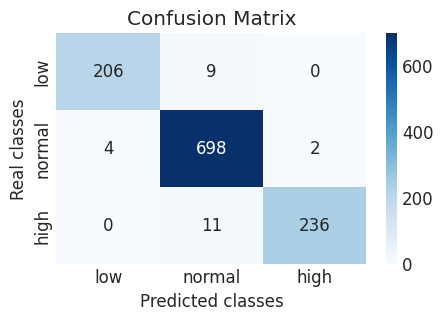


VALIDATION:
Accuracy: 0.9247
Macro F1: 0.9122

Classification Report:
              precision    recall  f1-score   support

         low       0.91      0.84      0.88        25
      normal       1.00      0.86      0.92        35
        high       0.90      0.98      0.94        86

    accuracy                           0.92       146
   macro avg       0.94      0.89      0.91       146
weighted avg       0.93      0.92      0.92       146



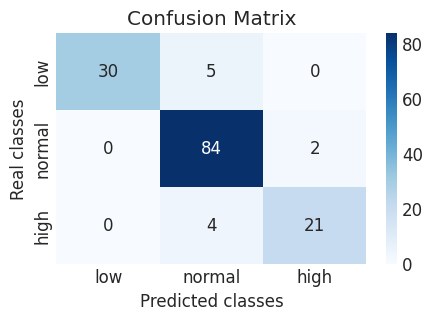


TEST:
Accuracy: 0.9247
Macro F1: 0.9163

Classification Report:
              precision    recall  f1-score   support

         low       0.93      0.87      0.90        30
      normal       0.93      0.90      0.92        30
        high       0.92      0.95      0.94        86

    accuracy                           0.92       146
   macro avg       0.93      0.91      0.92       146
weighted avg       0.92      0.92      0.92       146



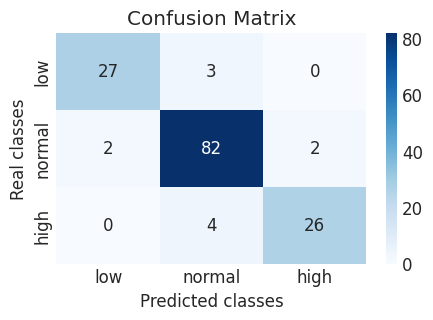

In [7]:
print(f"\nDETAILED EVALUATION OF BEST MODEL ({best_model_name})")

def evaluate_model(model, X, y_true, dataset_name):
    """Evaluate model on a dataset"""
    y_pred = model.predict(X)
    
    print(f"\n{dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['low', 'normal', 'high']))
    
    cm = confusion_matrix(y_true, y_pred, labels=['low', 'normal', 'high'])
    _, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['low', 'normal', 'high'],
            yticklabels=['low', 'normal', 'high'],
            ax=ax)
    ax.set_xlabel('Predicted classes')
    ax.set_ylabel('Real classes')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    return y_pred

y_train_pred = evaluate_model(best_model, X_train, y_train, "TRAIN")
y_val_pred = evaluate_model(best_model, X_val, y_val, "VALIDATION")
y_test_pred = evaluate_model(best_model, X_test, y_test, "TEST")


### 9. Analiza istotności cech

Ten blok kodu wykonuje **analizę istotności cech** dla najlepszego wytrenowanego modelu, **jeśli użyty klasyfikator ją wspiera** (np. RandomForest, DecisionTree).

Pozwala to zrozumieć, które cechy mają największy wpływ na przewidywanie kategorii cenowej (`low`, `normal`, `high`) i w jaki sposób model podejmuje decyzje.



In [8]:
info_dir = MODEL_DIR / f"price_classifier/info"

if hasattr(best_model.named_steps.get('model', None), 'feature_importances_'):
    print("\nFEATURE IMPORTANCE ANALYSIS")
    
    try:
        importances = best_model.named_steps['model'].feature_importances_
        try:
            feature_names = []
            if 'cat' in best_model.named_steps['preprocess'].named_transformers_:
                cat_transformer = best_model.named_steps['preprocess'].named_transformers_['cat']
                cat_encoder = cat_transformer.named_steps['onehot']
                cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
                feature_names.extend(cat_feature_names)
            
            if 'num' in best_model.named_steps['preprocess'].named_transformers_:
                feature_names.extend(numeric_features)
            
            if len(feature_names) == len(importances):
                feature_importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False)
                
                print("Top 20 most important features:")
                print(feature_importance_df.head(20).to_string(index=False))
            else:
                print("Warning: Feature count mismatch. Showing top indices instead.")
                idx_importance_df = pd.DataFrame({
                    'feature_index': range(len(importances)),
                    'importance': importances
                }).sort_values('importance', ascending=False)
                
                print("\nTop 20 most important feature indices:")
                print(idx_importance_df.head(20).to_string(index=False))
                
                print("\nMapping top indices to original features:")
                top_indices = idx_importance_df.head(10)['feature_index'].values
                for idx in top_indices:
                    if idx < len(numeric_features):
                        print(f"  Index {idx}: {numeric_features[idx]}")
                    else:
                        cat_idx = idx - len(numeric_features)
                        if cat_idx < len(feature_names) - len(numeric_features):
                            print(f"  Index {idx}: {feature_names[cat_idx + len(numeric_features)]}")
                
        except Exception as e:
            print(f"Could not get feature names: {e}")
            print(f"\nFeature importance range: {importances.min():.6f} to {importances.max():.6f}")
            print(f"Most important feature index: {np.argmax(importances)}")
            print(f"Least important feature index: {np.argmin(importances)}")
            
    except Exception as e:
        print(f"Error in feature importance analysis: {e}")


FEATURE IMPORTANCE ANALYSIS
Top 20 most important features:
                                         feature  importance
                       room_type_Entire home/apt    0.605042
              property_type_Private room in home    0.087536
            property_type_Private room in hostel    0.047780
                         property_type_Camper/RV    0.042755
                     host_location_Argos, Greece    0.026082
       property_type_Private room in guest suite    0.026017
                      property_type_Entire condo    0.012987
property_type_Private room in serviced apartment    0.012242
             property_type_Private room in condo    0.009298
              property_type_Private room in boat    0.006890
 property_type_Private room in bed and breakfast    0.005969
                property_type_Entire guest suite    0.005683
                        listing_location_ΖΑΠΠΕΙΟ    0.005315
                       listing_location_ΠΟΛΥΓΩΝΟ    0.005014
                  proper

### 10. Przykładowe przewidywania na danych testowych

Ten blok kodu pokazuje **przewidywania dla pojedynczych próbek**, wykonane przez najlepiej wytrenowany klasyfikator na wybranych przykładach z **zbioru testowego**.  

Umożliwia to:
- Porównanie **rzeczywistej kategorii ceny** z przewidywaną,
- Sprawdzenie **prawdopodobieństw przypisania do każdej klasy**,
- Identyfikację **przypadków błędnej klasyfikacji**.



In [9]:
print("\nEXAMPLE PREDICTIONS")
sample_indices = [0, 4, 9]

for i, idx in enumerate(sample_indices):
    sample = X_test.iloc[[idx]].copy()
    true_price = test_df.iloc[idx]['base_price']
    true_category = y_test.iloc[idx]
    
    pred_category = best_model.predict(sample)[0]
    
    if hasattr(best_model.named_steps['model'], 'predict_proba'):
        pred_proba = best_model.predict_proba(sample)[0]
    else:
        pred_proba = [0, 0, 0]
    
    print(f"\nExample {i + 1}:")
    print(f"  Price: ${true_price:.2f}")
    print(f"  Room Type: {sample['room_type'].iloc[0]}")
    print(f"  Location: {sample['listing_location'].iloc[0]}")
    print(f"  True Category: {true_category}")
    print(f"  Predicted Category: {pred_category}")
    
    if hasattr(best_model.named_steps['model'], 'predict_proba'):
        print(f"  Probabilities: high={pred_proba[0]:.3f}, low={pred_proba[1]:.3f}, normal={pred_proba[2]:.3f}")
    
    if true_category != pred_category:
        print(f"MISCLASSIFICATION")
    else:
        print(f"Correct classification")



EXAMPLE PREDICTIONS

Example 1:
  Price: $312.94
  Room Type: Entire home/apt
  Location: ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
  True Category: normal
  Predicted Category: normal
  Probabilities: high=0.008, low=0.063, normal=0.928
Correct classification

Example 2:
  Price: $2205.49
  Room Type: Entire home/apt
  Location: ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
  True Category: high
  Predicted Category: high
  Probabilities: high=0.959, low=0.002, normal=0.038
Correct classification

Example 3:
  Price: $163.92
  Room Type: Entire home/apt
  Location: ΚΕΡΑΜΕΙΚΟΣ
  True Category: low
  Predicted Category: low
  Probabilities: high=0.001, low=0.920, normal=0.079
Correct classification


### 11. Eksploracyjna analiza rozkładu cen i typów pokoi

Ten blok wykonuje **eksploracyjną analizę danych (EDA)** na zbiorze treningowym, aby lepiej zrozumieć:
- Zachowanie cen (`base_price`),
- Relacje między ceną a **typem pokoju** (`room_type`).



Analysis of Price Distribution and Room Types


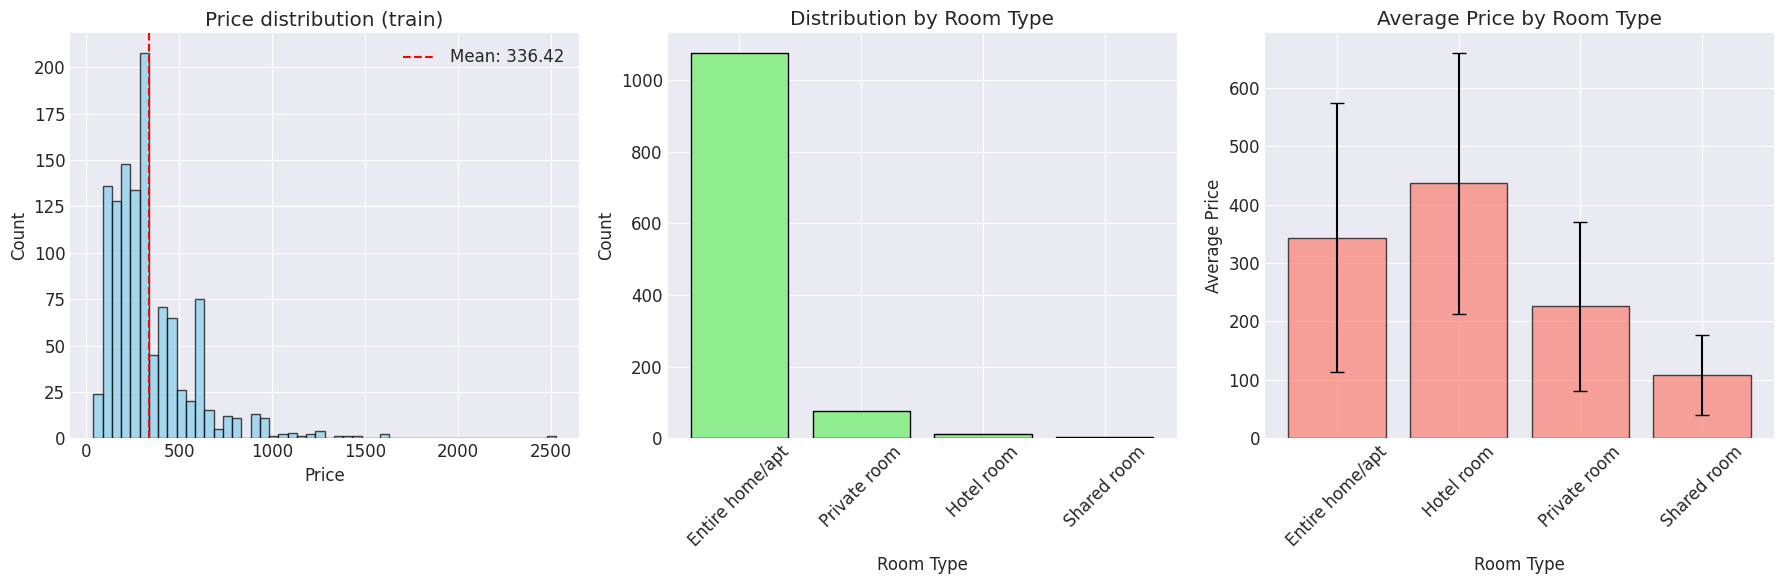

In [14]:
model = joblib.load(MODEL_DIR / "price_classifier/model.pkl")
with open(MODEL_DIR / "price_classifier/info" / "model_info.json", 'r') as f:
    model_info = json.load(f)

print("Analysis of Price Distribution and Room Types")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist(train_df['base_price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Price distribution (train)')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Count')
axes[0].axvline(train_df['base_price'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["base_price"].mean():.2f}')
axes[0].legend()

room_type_counts = train_df['room_type'].value_counts()
axes[1].bar(room_type_counts.index, room_type_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution by Room Type')
axes[1].set_xlabel('Room Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

room_price_stats = train_df.groupby('room_type')['base_price'].agg(['mean', 'std', 'count'])
axes[2].bar(room_price_stats.index, room_price_stats['mean'], 
            yerr=room_price_stats['std'], capsize=5, 
            color='salmon', edgecolor='black', alpha=0.7)
axes[2].set_title('Average Price by Room Type')
axes[2].set_xlabel('Room Type')
axes[2].set_ylabel('Average Price')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()